# Parameters

In [1]:
from typing import Dict, List
from collections import defaultdict

class Message:
    def __init__(self, sender, receiver, txid, sz):
        self.sender = sender
        self.receiver = receiver
        self.key = self.get_key(sender, receiver, txid)

        self.sz = sz
        self.start_ts = 0.0
        self.end_ts = 0.0
    
    @property
    def completion_time(self):
        return self.end_ts - self.start_ts
    
    @staticmethod
    def get_key(sender, receiver, txid):
        return "%s %s\t%s" % (sender, receiver, txid)
    
    def __str__(self):
        return f"{self.key}\t{self.completion_time}"

def process(tracefile):

    messages: Dict[str, List[Message]] = defaultdict(lambda: []) 
    messages_size2delays: Dict[int, List[float]] = defaultdict(lambda: []) 
    messages_allsizes: List[int] = []

    with open(tracefile, "r") as f:
        for line in f:
            log = line.split()
            ts = float(log[1]) * 1e-9   # seconds
            sz = int(log[2])            # bytes
            sender = log[3]             # ip:port
            receiver = log[4]             # ip:port
            txid = int(log[5])

            key = Message.get_key(sender, receiver, txid)

            if log[0] == "+":
                msg = Message(sender, receiver, txid, sz)
                msg.start_ts = ts
                messages[key].append(msg)
            elif log[0] == "-":
                msg = next((m for m in messages[key] if m.end_ts == 0), None)
                if not msg:
                    print("ERROR: cannot find start entry for ", line)
                    continue
                
                if msg.end_ts:
                    print("Message already has an end_ts!", msg)
                    continue
                
                msg.end_ts = ts
                messages_allsizes.append(msg.sz)
                messages_size2delays[msg.sz].append(msg.completion_time)

    all_messages_list = []
    for msgs in list(messages.values()):
        all_messages_list.extend(msgs)
    
    return all_messages_list

In [2]:
import matplotlib.pyplot as plt


## Average receiver bandwith utilization

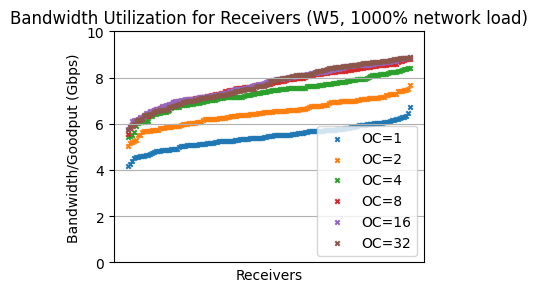

In [3]:
def chart(all_messages_list, color, label):
    rx_util = dict()

    recv_start_ts = defaultdict(lambda: 999999999999)
    recv_end_ts = defaultdict(lambda: 0)
    recv_bytes = defaultdict(int)

    for msg in all_messages_list:
        if not msg.end_ts:
            continue
        recv_start_ts[msg.receiver] = min(msg.start_ts, recv_start_ts[msg.receiver])
        recv_end_ts[msg.receiver] = max(msg.end_ts, recv_end_ts[msg.receiver])
        recv_bytes[msg.receiver] += msg.sz

    for r, totsz in recv_bytes.items():
        duration = recv_end_ts[r] - recv_start_ts[r]
        rx_util[r] = (totsz * 8 / duration) / 1024 / 1024 / 1024

    # Creating the scatter plot
    plt.scatter(rx_util.keys(), sorted(rx_util.values()), color=color, marker='x', label=label, s=10)


plt.figure(figsize=(4, 3))  # Set the figure size

file_template = "./MsgTraces_W5_load-1000p_0_OC?.tr"
OC_LEVELS = {
    1:"red",
    2:"orange",
    4:"yellow",
    8:"green",
    16:"blue",
    32:"purple"
}
for l, c in OC_LEVELS.items():
    filepath = file_template.replace("?", str(l))
    chart(process(filepath), color=None, label="OC="+str(l))
# chart(process("./MsgTraces_W5_load-80p_0_IMPORTANT.tr"), color="blue", label="80%")
# chart(process("./MsgTraces_W5_load-1000p_0_10x_load.tr"), color="red", label="1000%")

# Adding labels and title
plt.title('Bandwidth Utilization for Receivers (W5, 1000% network load)')
plt.xlabel('Receivers')
plt.ylabel('Bandwidth/Goodput (Gbps)')
plt.xticks([])
plt.ylim([0,10])
plt.legend()

# Show grid
# plt.grid(True)
plt.grid(axis='y', which='major')  # Show only horizontal grid lines on the y-axis

# Display the plot
plt.show()

# for msg in all_messages_list:
#     if msg.receiver in rx_util:
#         rx_util[msg.receiver] += msg.sz
#     else:
#         rx_util[msg.receiver] = msg.sz

# for k in rx_util.keys():
#     rx_util[k] /= max_bytes
#     if rx_util[k] > 1:
#         print("Hellfire!", rx_util[k])


